In [1]:
import numpy as np
import pyaudio
import wave
import matplotlib.pyplot as plt
import struct
from scipy.io import wavfile
import os
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
import sklearn
import pandas as pd
from scipy.fftpack import fft,fftfreq
from scipy import signal
import math
from scipy.signal import butter, lfilter, freqz

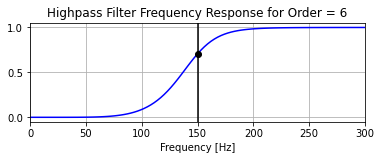

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='hp', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 48000    # sample rate, Hz
cutoff = 150  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_highpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, cutoff * 2)
plt.title(f"Highpass Filter Frequency Response for Order = {order}")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

In [3]:
# en_filter takes default value to enable filter, pass en_filter=0 to turn off filtering
def get_audio_data(rel_dir, en_filter = 1):
    width = 1000
    trim_value = 3750_00
    
    # data from audio files
    x = []
    # corresponding audio file class
    y = []
    # unique classes seen by the algorithm, for creating new classes dynamically
    classes = {};
    
    for item in os.listdir(rel_dir):
        # unqique identifier for file name
        identifier = item[0:12]
        
        # IF statements used to determine if class has been seen before
        if identifier in classes.keys():
            # assign class key to the list of labels
            y.append(classes[identifier])
            
        else:
            # checks if any classes have been added yet
            if( classes):
                # add class file name identifier to the classes, assign index one higher than maximum value present
                classes[identifier] = max(classes.values()) + 1
            else:
                classes[identifier] = 0
            # append new class to list of labels
            y.append(classes[identifier])
        
        
        samplerate, data = wavfile.read(f'{rel_dir}/{item}')
        
        #### ALL CODE BELOW IS DEDICATED TO FEATURE ENGINEERING
        
        # trim first 60k samples (shortly after clap)
        data = data[60000:]
        
        
        # mean center and scale data
        data = (data - data.mean()) / data.std()
        
        # filter using HPF
        if( en_filter):
            data = butter_highpass_filter(data, cutoff, fs, order);
        data = np.abs(data)

        # compresses data into bins to reduce dimentionality, works great after filter
        data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)
                
        # looks at the data for the first non-zero value (first peak in wave)
        first_peak = -1
        for i in range(data.size):
            if( data[i] != 0 and first_peak == -1):
                first_peak = i
        #trim from first peak onwards to end (sound runs long anways)
        data = data[first_peak:]

        # trims from end to have normalized size, scaled by width to accomidate different binning
        data = data[:int(trim_value/width)]
        
        # If peak value < 0.5 must be ambient noise
        #print(f"{np.max(data)} {item}")
        if ( np.max(data) < 0.36 and en_filter):
            data[:] = 0
            #print(item)
        
        x.append(data)
            
        
            
    x = np.array(x)
    y = np.array(y)
    return x, y

In [7]:
x, y = get_audio_data("./training")

#nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=1) #20
nn = linear_model.LogisticRegression(solver = "liblinear" )
#nn = svm.NuSVC()

nn.fit(x,y);

xt, yt = get_audio_data("./testing")


pred =  nn.predict(xt)

# formats the prediction values to string labels (refer to function below)
predicted = confusion_format(pred)
# formats the actual labels to string values (refer to function below)
actual = confusion_format(yt)
# prints the confusion matrix using string labels
print(pd.crosstab(actual, predicted, rownames=["Actual"], colnames=["Predicted"]))

#print(pd.crosstab(yt, pred))
print(f"\nPercentage correct: {error_percentage(pred, y)}")


Predicted    Ambient  Consecutive  FullTray  LidOff  LidOn
Actual                                                    
Ambient            5            0         0       0      0
Consecutive        0           10         0       0      0
FullTray           0            1         9       0      0
LidOff             0            0         0      10      0
LidOn              0            1         0       0      9

Percentage correct: 95.55555555555556


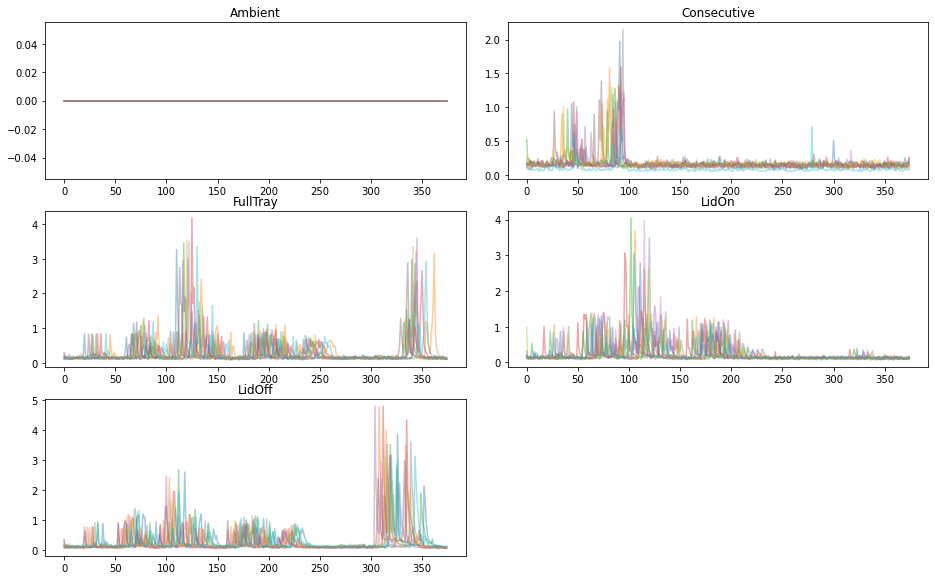

In [8]:
x, y = get_audio_data("./training")
fig, ax = plt.subplots(3, 2, figsize=(13,8))
fig.tight_layout()

indices = {
    0 : [0, 0],
    1 : [0, 1],
    2 : [1, 0],
    3 : [1, 1],
    4 : [2, 0]
}

index = 1
lag = 0
for i in range(len(y)):
    if( y[i] != lag):
        index = index + 1
        lag = y[i]
    ii = indices[y[i]][0]
    j = indices[y[i]][1]
    ax[ii][j].plot(x[i], alpha = 0.4)
    ax[ii][j].title.set_text(confusion_format([y[i]])[0])
ax[2][1].set_visible(False)

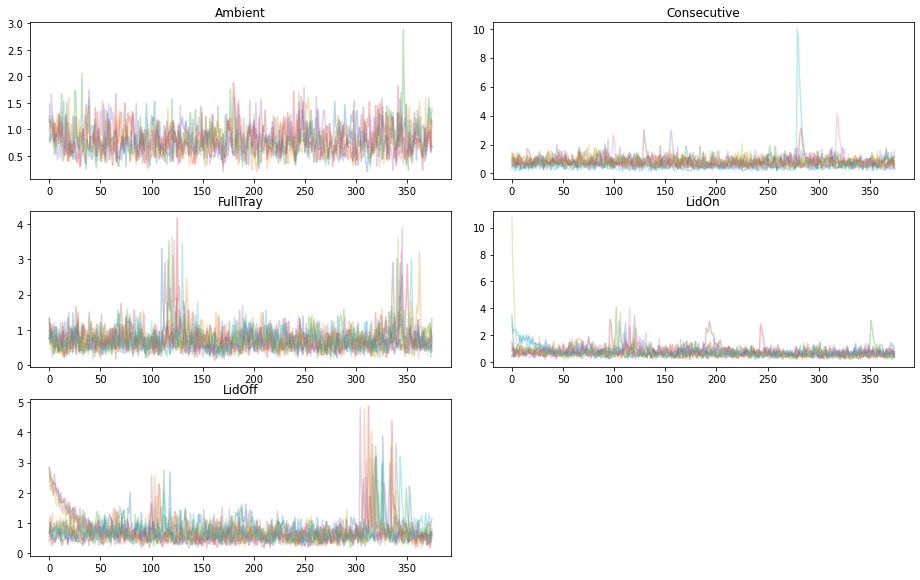

In [9]:
x, y = get_audio_data("./training", 0)
fig, ax = plt.subplots(3, 2, figsize=(13,8))
fig.tight_layout()

indices = {
    0 : [0, 0],
    1 : [0, 1],
    2 : [1, 0],
    3 : [1, 1],
    4 : [2, 0]
}

index = 1
lag = 0
for i in range(len(y)):
    if( y[i] != lag):
        index = index + 1
        lag = y[i]
    ii = indices[y[i]][0]
    j = indices[y[i]][1]
    ax[ii][j].plot(x[i], alpha = 0.3)
    ax[ii][j].title.set_text(confusion_format([y[i]])[0])
ax[2][1].set_visible(False)

In [11]:
print(nn.intercept_)
print(nn.coef_)

[ 0.95569551 -0.86966587 -1.3270554  -1.27079454 -1.32791782]
[[-0.09155243 -0.05741803 -0.0586494  ... -0.04987703 -0.05540742
  -0.05619094]
 [ 0.09594218  0.12171418  0.13615353 ...  0.10139262  0.12141123
   0.14841128]
 [-0.13921878 -0.04017076 -0.04059362 ... -0.0279258  -0.03411868
  -0.05699292]
 [ 0.07200519 -0.04382206 -0.05504389 ... -0.03041822 -0.04034646
  -0.04334735]
 [-0.04334563 -0.05862284 -0.05980796 ... -0.05476459 -0.06070997
  -0.06383336]]


In [21]:
df = pd.DataFrame(nn.coef_)
df.insert(0, "intercept", nn.intercept_)
display(df)
df.to_csv("ML_intercept_and_coefs.csv")

,intercept,0,1,2,3,4,5,6,7,8,...,365,366,367,368,369,370,371,372,373,374
0,0.955696,-0.091552,-0.057418,-0.058649,-0.057495,-0.054770,-0.057508,-0.052356,-0.054083,-0.054540,...,-0.052240,-0.048336,-0.043924,-0.048258,-0.050990,-0.056454,-0.049605,-0.049877,-0.055407,-0.056191
1,-0.869666,0.095942,0.121714,0.136154,0.123325,0.127719,0.085126,0.100544,0.097726,0.083321,...,0.067939,0.078345,0.038322,0.089668,0.087266,0.116149,0.089323,0.101393,0.121411,0.148411
2,-1.327055,-0.139219,-0.040171,-0.040594,-0.050292,-0.037203,-0.041641,-0.038069,-0.046768,-0.057852,...,0.000726,-0.009204,0.004340,-0.023329,-0.023736,-0.018689,-0.015603,-0.027926,-0.034119,-0.056993
3,-1.270795,0.072005,-0.043822,-0.055044,-0.045285,-0.046528,-0.006209,-0.027258,-0.012266,0.000778,...,-0.040864,-0.035987,-0.030887,-0.040584,-0.037303,-0.055347,-0.034869,-0.030418,-0.040346,-0.043347
4,-1.327918,-0.043346,-0.058623,-0.059808,-0.046715,-0.061972,-0.057655,-0.054791,-0.055919,-0.047148,...,-0.046030,-0.047055,-0.026696,-0.039913,-0.041930,-0.057098,-0.055065,-0.054765,-0.060710,-0.063833


In [5]:
def error_percentage(pred, y):
    
    #print(pred)
    #print(y)
    # the number of errors is the number of differences between the model's labels and the correct labels
    errors = 0
    for i in range(pred.size):
        # pred is the predicted array labels, while y is the actual
        if pred[i] != y[i]:
            errors = errors + 1
            
    # then the percentage of errors is the number of errors divided by the total number of image samples times 100 for percentage.
    return 100 - errors / pred.size * 100

In [6]:
def confusion_format(labels):
    test = []
    for i in labels:
        if i == 0:
            test.append("Ambient")
        elif i == 1:
            test.append("Consecutive")
        elif i == 2:
            test.append("FullTray")
        elif i == 3:
            test.append("LidOn")
#         elif i == 4:
#             test.append("NoPiece")
        else:
            test.append("LidOff")
    test = np.array(test)
    return test